In [73]:
import numpy as np
import pandas as pd
import cv2
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.metrics import classification_report,confusion_matrix

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn
import joblib
import json

In [3]:
img = cv2.imread("C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Leonardo DiCaprio/001_08194468.jpg")
img.shape

(474, 474, 3)

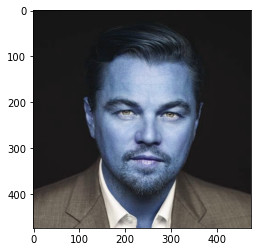

In [4]:
plt.imshow(img)

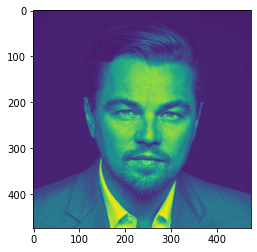

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)


(474, 474)

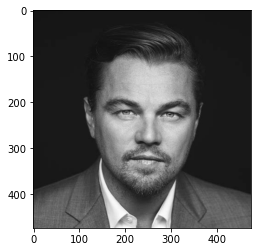

In [6]:
plt.imshow(gray, cmap = 'gray')
gray.shape

In [7]:
print(cv2.__file__)

C:\Users\AbhinaV\anaconda3\lib\site-packages\cv2\__init__.py


In [8]:
#face_cascade = cv2.CascadeClassifier("C:/Users/AbhinaV/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml")
#eye_cascade = cv2.CascadeClassifier("C:/Users/AbhinaV/anaconda3/Lib/site-packages/cv2/data/haarcascade_eye")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray)
print(faces)

[[124 120 257 257]]


In [9]:
x,y,w,h = faces[0]
x,y,w,h

(124, 120, 257, 257)

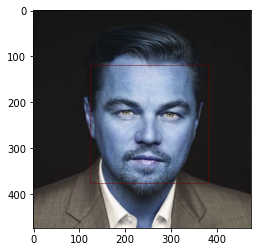

In [10]:
faceimg = cv2.rectangle(img,(x,y),(x+w,y+h),(122,0,0),0)
plt.imshow(img)

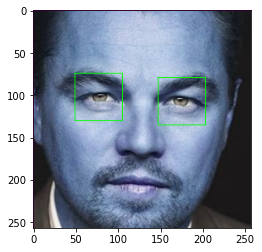

In [11]:
#cv2.destroyAllWindows()
for(x,y,w,h) in faces:
    faceimg = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),0)
    roi_gray = gray[y:y+h , x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    roi_color = faceimg[y:y+h , x:x+w]
    for(ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),0)

plt.figure()
plt.imshow(faceimg,cmap = 'gray')
plt.show
plt.imshow(roi_color,cmap = 'gray')

In [12]:
def crop_img(img_path):
    #print(img_path)
    img = cv2.imread(img_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for(x,y,w,h) in faces:
        if img is None:
            continue
        roi_gray = gray[y:y+h , x:x+w]
        roi_color = img[y:y+h , x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if(len(eyes)>=2):
            return roi_color

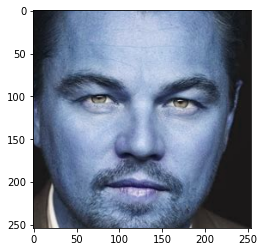

In [13]:
temp = crop_img("C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Leonardo DiCaprio/001_08194468.jpg")
plt.imshow(temp)

In [14]:
path_to_data = "C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/"
path_to_cr_data = "C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/"


In [15]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [16]:
img_dirs

['C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Johnny Depp',
 'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Leonardo DiCaprio',
 'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Robert Downey Jr',
 'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Scarlett Johansson']

In [26]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [27]:
cropped_img_dirs = []
player_file_names_dict = {}

for img_dir in img_dirs:
    player_name = img_dir.split('/')[-1]
    
    count = 1
    player_file_names_dict[player_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = crop_img(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + player_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("generating images in folder: ", cropped_folder)
                
            cropped_file_name = player_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            player_file_names_dict[player_name].append(cropped_file_path)
            count = count + 1

generating images in folder:  C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp
generating images in folder:  C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Leonardo DiCaprio
generating images in folder:  C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Robert Downey Jr
generating images in folder:  C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Scarlett Johansson


In [28]:
print(player_file_names_dict.keys())

dict_keys(['Johnny Depp', 'Leonardo DiCaprio', 'Robert Downey Jr', 'Scarlett Johansson'])


In [29]:
def w2d(img):
    mode = 'db1'
    level = 5
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray = imArray/255
    coeffs = pywt.wavedec2(imArray,mode,level)
    coeffs_H = list(coeffs)
    coeffs_H[0] = coeffs_H[0]*0;
    imArray_H = pywt.waverec2(coeffs_H,mode)
    imArray_H = imArray_H * 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

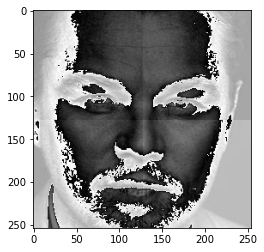

In [30]:
im_har = w2d(temp)
plt.imshow(im_har,cmap = 'gray')

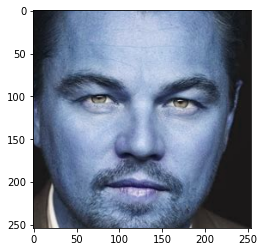

In [33]:
temp1 = crop_img("C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Leonardo DiCaprio/001_08194468.jpg")
plt.imshow(temp1)

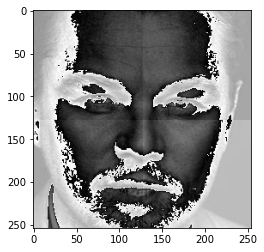

In [34]:
im_har = w2d(temp1)
plt.imshow(im_har,cmap = 'gray')

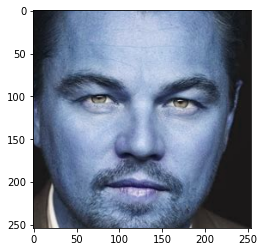

In [35]:
temp2 = crop_img("C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/Leonardo DiCaprio/001_08194468.jpg")
plt.imshow(temp2)

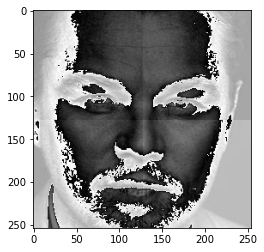

In [36]:
im_har = w2d(temp2)
plt.imshow(im_har,cmap = 'gray')

In [37]:
player_dict = {}
for img_dir in cropped_img_dirs:
    player_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    player_dict[player_name] = file_list
player_dict

{'Johnny Depp': ['C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp1.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp10.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp11.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp12.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp13.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp14.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp15.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp16.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp17.png',
  'C:/Users/AbhinaV/Desktop/race_classifier/model/dataset/cropped/Johnny Depp\\Johnny Depp18.pn

In [38]:
class_dict = {}
count = 0
for player in player_dict.keys():
    class_dict[player] = count
    count = count + 1
    

x = []
y = []

for player, training_files in player_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img)
        scalled_img_har = cv2.resize(img_har,(32,32))
        combined_image = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        x.append(combined_image)
        y.append((player))

In [39]:
print(class_dict)

{'Johnny Depp': 0, 'Leonardo DiCaprio': 1, 'Robert Downey Jr': 2, 'Scarlett Johansson': 3}


In [40]:
len(x[0])


4096

In [41]:
len(y)

373

In [42]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(373, 4096)

In [49]:
x_train , x_test, y_train, y_test = train_test_split(x,y,random_state = False)
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel = 'rbf',C=10))])
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)


0.8191489361702128

In [50]:
print(classification_report(y_test, pipe.predict(x_test)))

                    precision    recall  f1-score   support

       Johnny Depp       0.75      0.75      0.75        16
 Leonardo DiCaprio       0.81      0.95      0.88        22
  Robert Downey Jr       1.00      0.27      0.42        15
Scarlett Johansson       0.83      0.98      0.90        41

          accuracy                           0.82        94
         macro avg       0.85      0.74      0.74        94
      weighted avg       0.84      0.82      0.79        94



In [51]:
print(len(x_test),len(y_test),len(x_train),len(y_train))

94 94 279 279


In [52]:
model_params = {
    'svm':{
        'model' : svm.SVC(gamma = 'auto',probability = True),
        'params' : {
            'svc__C':[1,10,100,1000],
            'svc__kernel':['rbf','linear']
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[1,5,10]
        }
    },
    'logictic_regression':{
        'model':LogisticRegression(solver = 'liblinear',multi_class = 'auto'),
        'params':{
            'logisticregression__C':[1,5,10]
        }
    }
}

In [53]:
scores = []
best_estimators = {}
for algo , mp in model_params.items():
    pipe = make_pipeline(StandardScaler(),mp['model'])
    clf = GridSearchCV(pipe,mp['params'],cv = 5,return_train_score = False)
    clf.fit(x_train, y_train)
    scores.append({
        'model':algo,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns = ['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.781169,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.609221,{'randomforestclassifier__n_estimators': 5}
2,logictic_regression,0.834805,{'logisticregression__C': 10}


In [54]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logictic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [55]:
best_estimators['svm'].score(x_test,y_test)

0.8404255319148937

In [56]:
best_estimators['random_forest'].score(x_test,y_test)

0.5957446808510638

In [59]:
best_estimators['logictic_regression'].score(x_test,y_test)

0.8936170212765957

In [61]:
best_clf = best_estimators['logictic_regression']

In [64]:
print(confusion_matrix(y_test,best_clf.predict(x_test)))

[[13  2  1  0]
 [ 0 21  0  1]
 [ 3  2 10  0]
 [ 0  1  0 40]]


Text(33.0, 0.5, 'Truth')

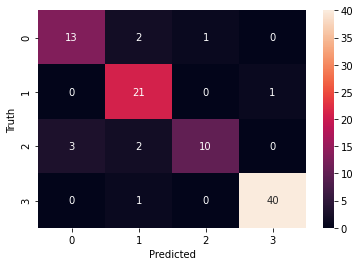

In [68]:
seaborn.heatmap(confusion_matrix(y_test,best_clf.predict(x_test)), annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [69]:
print(class_dict)

{'Johnny Depp': 0, 'Leonardo DiCaprio': 1, 'Robert Downey Jr': 2, 'Scarlett Johansson': 3}


In [74]:
joblib.dump(best_clf,'final_model.pkl')
with open("class_dictionary","w") as f:
    f.write(json.dumps(class_dict))